In [44]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate, train_test_split
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

In [2]:
# Load the .mat file
mat_file = scipy.io.loadmat('general/full_data.mat')

# Access the variables stored in the file
print(mat_file.keys())


dict_keys(['__header__', '__version__', '__globals__', 'aligned_zscores', 'folders', 'mean_normed_ZScores', 'unaligned_dFF', 'unaligned_zscores'])


In [26]:
mouse_ids = scipy.io.loadmat('general/Mouse_Ids.mat')['mouse_id']

## Things we want to do
### Cell Clustering
cell by stim condition by trial by time = 153 x ...
### PCA of population activity PC1, PC2, and time
### SVM or linear decoding of population activity
binary vs multiclass 
### How many neurons needed

## Cell Clustering

In [57]:
# because the mice have different trials, our data matrix will be the average response per trial type
#( # neurons, trial_type x time)
cell_condition_array = np.zeros((mat_file['aligned_zscores'].shape[0], mat_file['aligned_zscores'].shape[1], mat_file['aligned_zscores'][0,0].shape[1]))
for mouse_id in np.unique(mouse_ids):
    for stim_condition_idx in range(mat_file['aligned_zscores'].shape[1]):
        mouse_neurons = np.where(mouse_ids[:, 0] == mouse_id)[0]
        mouse_stim_trials = [mat_file['aligned_zscores'][i, stim_condition_idx] for i in mouse_neurons]
        mean_mouse_stim_trials = np.mean(np.array(mouse_stim_trials), axis=1)
        cell_condition_array[mouse_neurons, stim_condition_idx, :] = mean_mouse_stim_trials

    

In [58]:
cell_array = cell_condition_array.reshape((cell_condition_array.shape[0], -1))

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

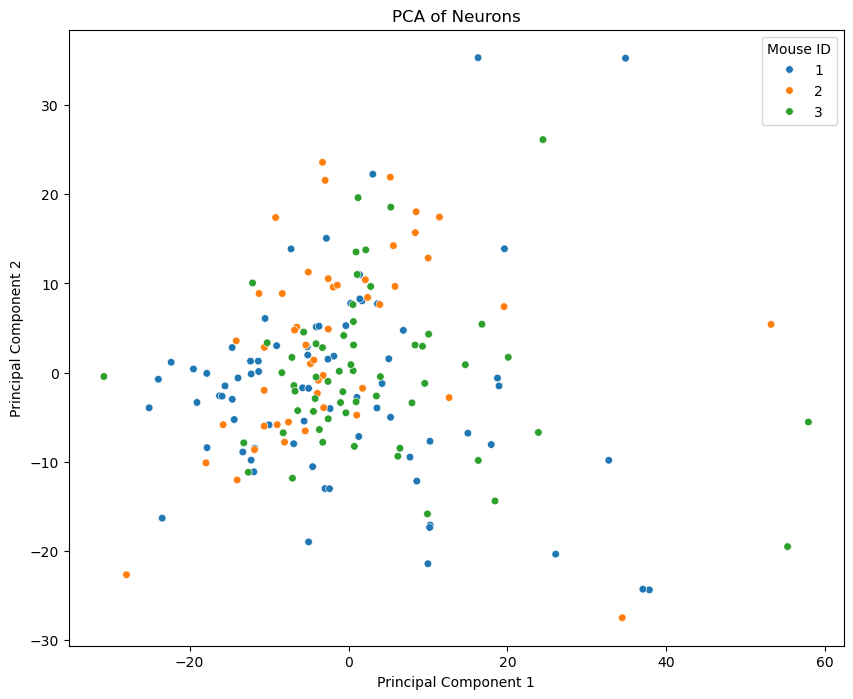

In [62]:
from sklearn.decomposition import PCA
# Perform PCA on the flattened cell array
pca = PCA(n_components=3)
pca_result = pca.fit_transform(cell_array)
# Plot the PCA result
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=mouse_ids[:, 0], palette='tab10', s=30)
plt.title('PCA of Neurons')
plt.legend(title='Mouse ID')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend

Text(0.5, 1.0, 't-SNE of Neurons')

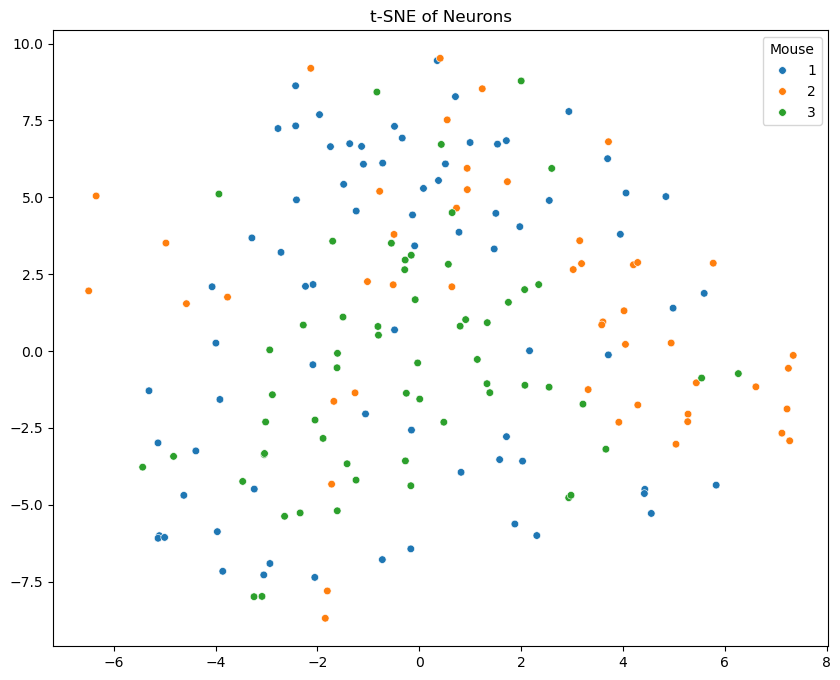

In [61]:
# try tsne
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(cell_array)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=mouse_ids[:, 0], palette='tab10', s=30)
plt.legend(title='Mouse')
plt.title('t-SNE of Neurons')

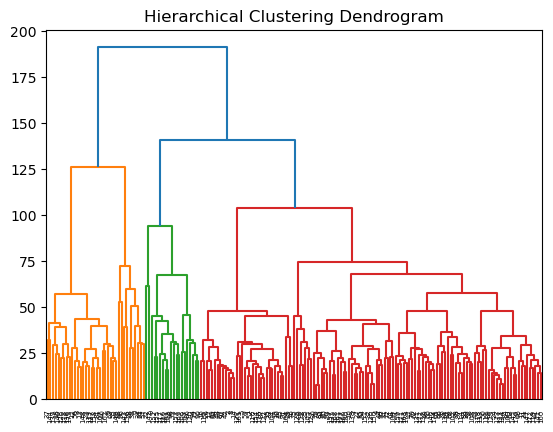

In [51]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

labels = model.fit_predict(cell_array)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model)

In [55]:
model = AgglomerativeClustering(n_clusters=3)

labels = model.fit_predict(cell_array)

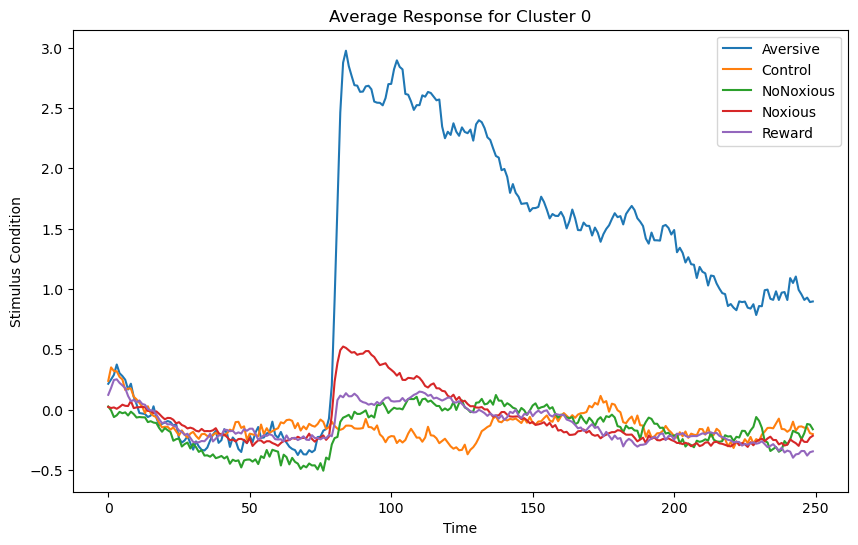

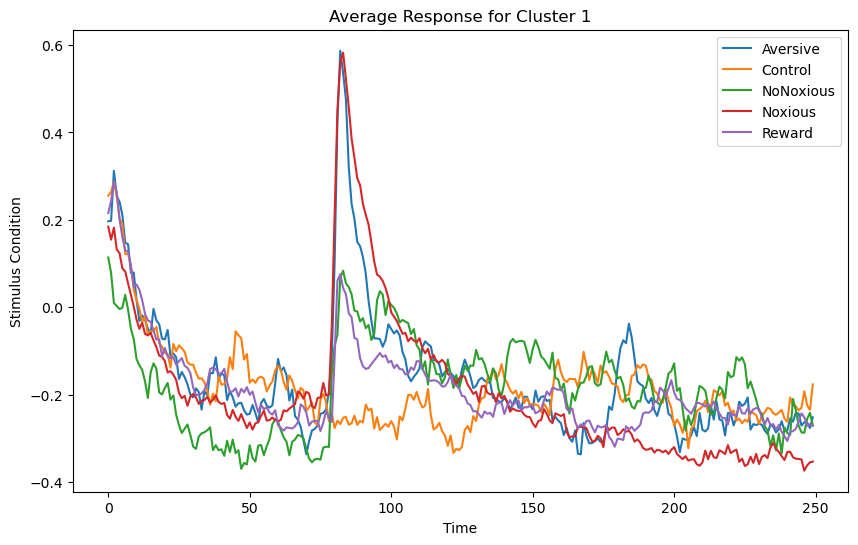

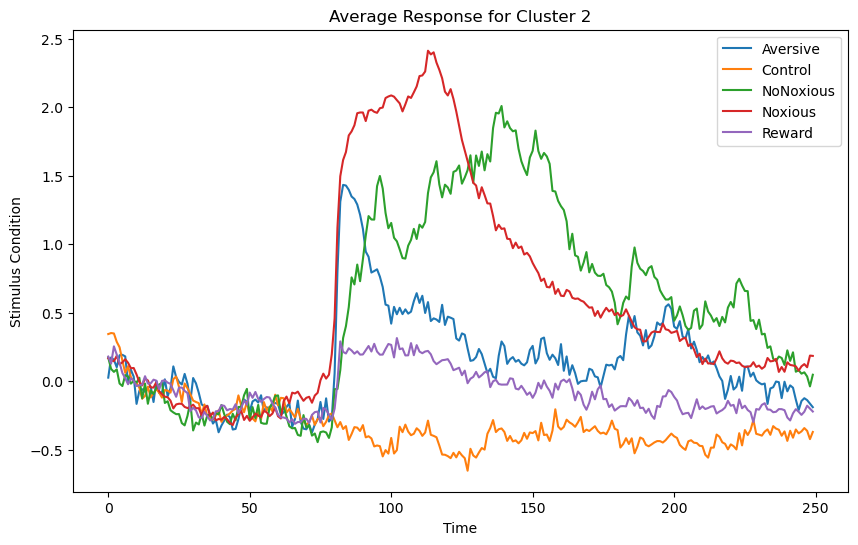

In [63]:
# Plot average response per cluster
#unflatten cell array
for cluster_id in np.unique(labels):
    cluster_neurons = np.where(labels == cluster_id)[0]
    mean_response = np.mean(cell_condition_array[cluster_neurons, :, :], axis=0)
    plt.figure(figsize=(10, 6))
    plt.plot(mean_response.T)
    plt.title(f'Average Response for Cluster {cluster_id}')
    plt.xlabel('Time')
    plt.ylabel('Stimulus Condition')
    plt.legend(['Aversive', 'Control', 'NoNoxious', 'Noxious', 'Reward'])
    plt.show()

## Population activity

In [65]:
# make array that is of trial (concat across stim condition), time, cell per mouse
mouse_trial_arrays = {}
for mouse_id in np.unique(mouse_ids):
    mouse_neurons = np.where(mouse_ids[:, 0] == mouse_id)[0]
    trial_array = []
    for stim_condition_idx in range(mat_file['aligned_zscores'].shape[1]):
        per_stim_condition_array = np.zeros((mat_file['aligned_zscores'][mouse_neurons[0], stim_condition_idx].shape[0], 250, len(mouse_neurons)))
        for i, cell in enumerate(mouse_neurons):
            per_stim_condition_array[:, :, i] = mat_file['aligned_zscores'][cell, stim_condition_idx]
        trial_array.append(per_stim_condition_array)
    trial_array = np.concatenate(trial_array, axis=0)
    mouse_trial_arrays[mouse_id] = trial_array

### SVM of trial

In [66]:
# Now do (trial, time*cell)
mouse_trial_pop_arrays = {}
for mouse_id in mouse_trial_arrays.keys():
    trial_array = mouse_trial_arrays[mouse_id]
    trial_pop_array = trial_array.reshape(trial_array.shape[0], -1)
    mouse_trial_pop_arrays[mouse_id] = trial_pop_array


In [70]:
mouse_stim_labels = {}
for mouse_id in mouse_trial_arrays.keys():
    mouse_neurons = np.where(mouse_ids[:, 0] == mouse_id)[0]
    stim_labels = []
    for stim_condition_idx in range(mat_file['aligned_zscores'].shape[1]):
        stim_labels += [stim_condition_idx]*mat_file['aligned_zscores'][mouse_neurons[0],stim_condition_idx].shape[0]
    mouse_stim_labels[mouse_id] = np.array(stim_labels)

In [68]:

def svm_simulations(trial_array, stim_labels, task, simulation_trials=1000, neuron_subset=1):
    accuracies = []
    tasks = []
    shuffleds = []
    for simulation_idx in range(simulation_trials):
        if neuron_subset < 1:
            # Randomly select a subset of neurons
            num_neurons = int(trial_array.shape[-1] * neuron_subset)
            selected_neurons = np.random.choice(trial_array.shape[-1], num_neurons, replace=False)
            trial_array_subset = trial_array[:, :, selected_neurons]
            trial_pop_array_subset = trial_array_subset.reshape(trial_array_subset.shape[0], -1)
        else:
            trial_pop_array_subset =  trial_array.reshape(trial_array.shape[0], -1)
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(trial_pop_array_subset, stim_labels, test_size=0.2, random_state=42)

        # Create a LinearSVC model
        svm = LinearSVC(random_state=42)
        svm.fit(X_train, y_train)
        accuracies.append(svm.score(X_test, y_test))
        tasks.append(task)
        shuffleds.append(False)
        
        # Shuffle the labels and repeat
        shuffled_labels = np.random.permutation(stim_labels)
        X_train, X_test, y_train, y_test = train_test_split(trial_pop_array_subset, shuffled_labels, test_size=0.2, random_state=42)
        svm.fit(X_train, y_train)
        accuracies.append(svm.score(X_test, y_test))
        tasks.append(task)
        shuffleds.append(True)
    return accuracies, tasks, shuffleds

In [71]:
df = pd.DataFrame(columns=['Accuracy', 'Task', 'Shuffled'])
for mouse_id in mouse_trial_pop_arrays.keys():
    accuracies, tasks, shuffleds = svm_simulations(mouse_trial_pop_arrays[mouse_id], mouse_stim_labels[mouse_id], task=f'Mouse {mouse_id}', simulation_trials=100)
    df = pd.concat([df, pd.DataFrame({'Accuracy': accuracies, 'Task': tasks, 'Shuffled': shuffleds})], ignore_index=True)

/var/folders/l6/cbgzz_j53gb34t8y66wdpxkc0000gn/T/ipykernel_26954/4203893726.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'Accuracy': accuracies, 'Task': tasks, 'Shuffled': shuffleds})], ignore_index=True)


Text(0.5, 1.0, 'SVM Multi-class Classification Accuracy by Mouse')

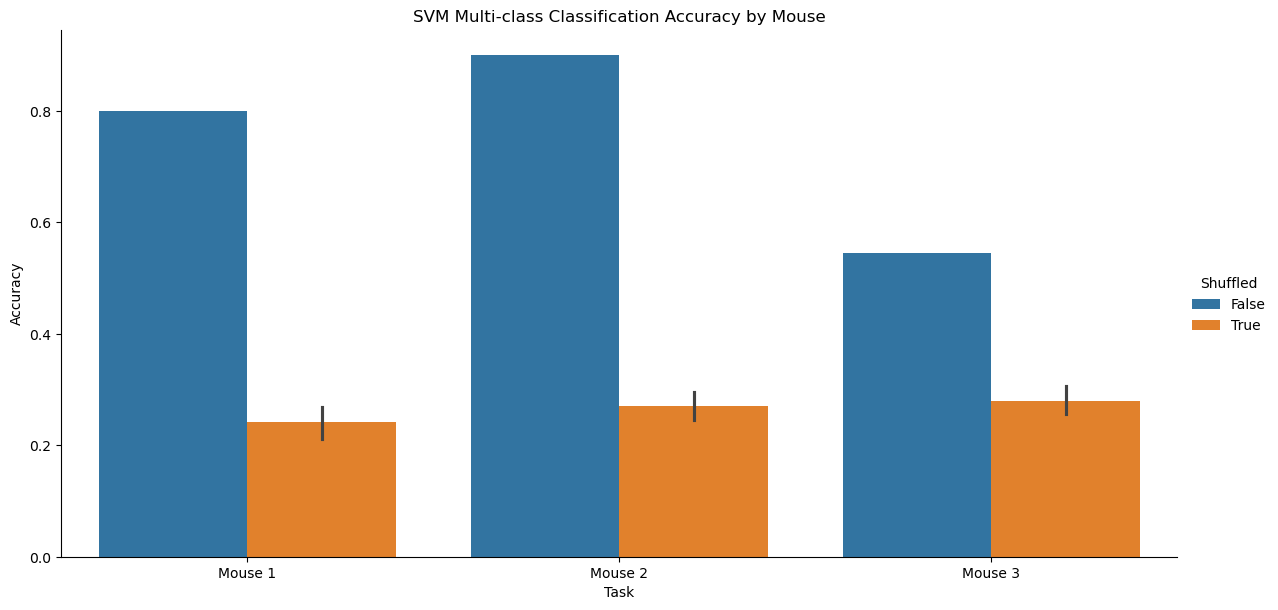

In [76]:
sns.catplot(data=df, x='Task', y='Accuracy', hue='Shuffled', kind='bar', height=6, aspect=2)
plt.title('SVM Multi-class Classification Accuracy by Mouse')

Text(0.5, 1.0, 'SVM Multi-class Classification Accuracy')

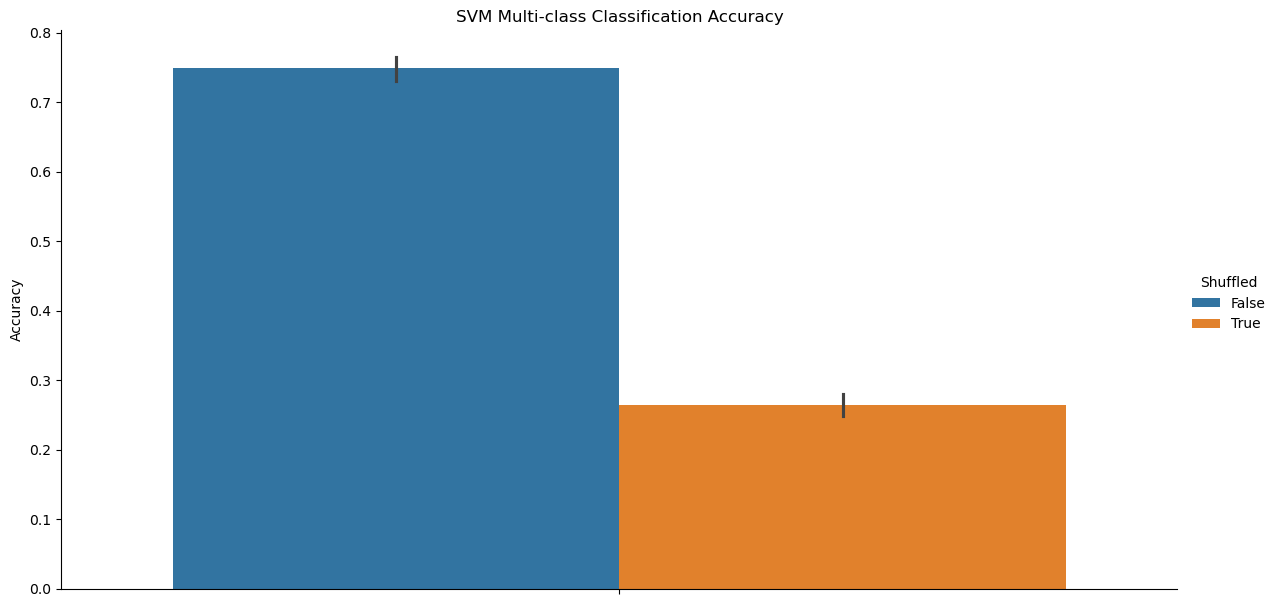

In [77]:
sns.catplot(data=df, y='Accuracy', hue='Shuffled', kind='bar', height=6, aspect=2)
plt.title('SVM Multi-class Classification Accuracy')